## Automatic Differentiation

In [10]:
"""
This script prepares your Python environment by loading essential tools for handling environment variables, 
interacting with a Neo4j graph database, and utilizing a bespoke graph module, which could be sourced 
from either a local graph class or optionally from the trengx package.

import os: 
This line imports the built-in Python module os, which provides a portable way of using 
operating system dependent functionality, like reading or writing to the environment.

from dotenv import load_dotenv: 
This line imports the load_dotenv function from the dotenv module. 
This function reads a file (by default, a file named .env in the same directory as the script) and 
loads its contents as environment variables.

from neo4j import GraphDatabase as graphdb: 
This line imports the GraphDatabase class from the neo4j module, and renames it to graphdb 
in your script for convenience. This class is used to interact with a Neo4j graph database.

import sys and sys.path.append('../trengx'): 
These lines modify the system path that Python uses to look for modules. The sys module provides access 
to some variables used or maintained by the Python interpreter. In this case, it's used to add 
the parent directory's trengx subdirectory to the list of directories that Python will search when you import a module.

import graph: This line imports the graph module, which is expected to be found in the trengx directory 
that was just added to the system path. This module likely contains the Graph class that you use in your script. 
The specific functionality of this module depends on its implementation, but based on context, 
it likely provides tools for creating and manipulating a computational graph.
"""

# %pip install trengx
# from trengx import graph

import os
import sys
sys.path.append('../trengx')
import graph

In [11]:
# Retrieve secrets (confidential credentials) from environment variables stored in .env file
uri = os.getenv('NEO4J_URI') # Get the value of the uri variable
user = os.getenv('NEO4J_USER') # Get the value of the user variable
password= os.getenv('NEO4J_PASSWORD')  # Get the value of the password variable

# Create a Graph class instance using Graph class in neo4j_graph.py (module)
g = graph.Graph(uri, user, password)

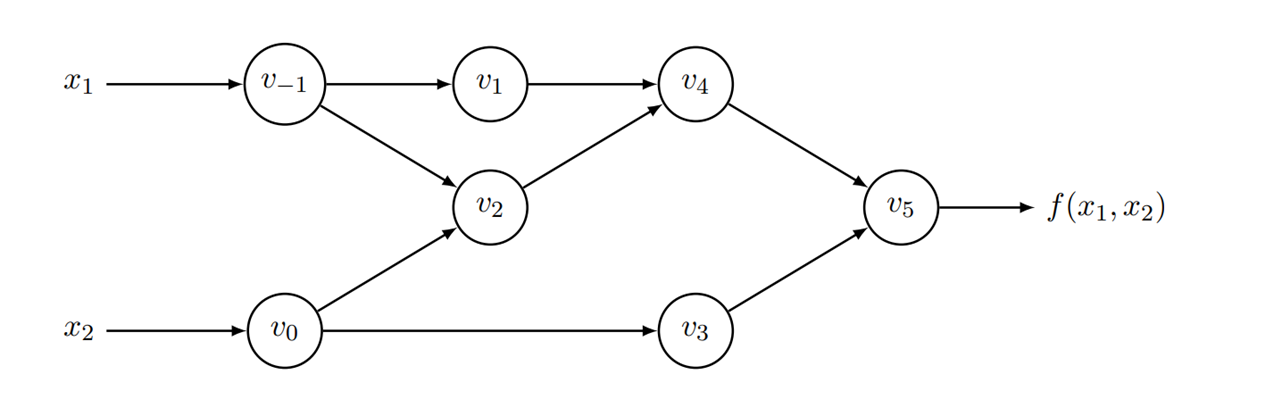

In [12]:
g.delete_all()

# w_est_i = 0.1
w_est_i = g.add_node('num', {'name': 'w_est_i', 'value': 0.1})  # Variable representing w_est[i]
w_est_i_id = w_est_i['id']

# y_im1 = 10
y_im1 = g.add_node('num', {'name': 'y_im1', 'value': 10})  # Variable representing y[i-1]
y_im1_id = y_im1['id']

# mul: multiplication
mul1 = g.add_node('op', {'name': '*', 'reverse': False})  # Multiplication operation
mul1_id = mul1['id']

# Connect w_est_i and y_im1 to the mul operation
g.add_edge('num2op', w_est_i_id, mul1_id, {'trigger': False})  # Edge from w_est_i to mul (passive)
g.add_edge('num2op', y_im1_id, mul1_id, {'trigger': True})  # Edge from y_im1 to mul (active)

# y_est_i = w_est_i * y_im1
y_est_i = g.add_node('num', {'name': 'y_est_i', 'value': 0})  # Variable representing y_est[i]
y_est_i_id = y_est_i['id']
g.add_edge('op2num', mul1_id, y_est_i_id, {'trigger': True})  # Edge from mul to y_est_i (active)

# y_i = 10
y_i = g.add_node('num', {'name': 'y_i', 'value': 10})  # Variable representing y[i]
y_i_id = y_i['id']

# sub: subtraction
sub = g.add_node('op', {'name': '-', 'reverse': True})  # Subtraction operation
sub_id = sub['id']

# Connect y_i and y_est_i to the sub operation
g.add_edge('num2op', y_i_id, sub_id, {'trigger': False})  # Edge from y_i to sub (passive)
g.add_edge('num2op', y_est_i_id, sub_id, {'trigger': True})  # Edge from y_est_i to sub (active)

# e_i = y_i - y_est_i
e_i = g.add_node('num', {'name': 'e_i', 'value': 0.0})  # Variable representing e[i]
e_i_id = e_i['id']
g.add_edge('op2num', sub_id, e_i_id, {'trigger': True})  # Edge from sub to e_i (active)

mul2 = g.add_node('op', {'name': '*', 'reverse': False})  # Multiplication operation
mul2_id = mul2['id']

# Connect y_im1 and e_i to the mul operation
g.add_edge('num2op', y_im1_id, mul2_id, {'trigger': False})  # Edge from y_im1 to mul (passive)
g.add_edge('num2op', e_i_id, mul2_id, {'trigger': True})  # Edge from e_i to mul (active)

# temp1 = 1.0
temp1 = g.add_node('num', {'name': 'temp1', 'value': 0.0})  # Variable representing temp1
temp_id_1 = temp1['id']

# Connect mul and temp1 with a * operation
g.add_edge('op2num', mul2_id, temp_id_1, {'trigger': True})  # Edge from mul to temp1 (active)

# lr = 0.001
lr = g.add_node('num', {'name': 'lr', 'value': 0.001})  # Variable representing lr
lr_id = lr['id']

# Connect temp1 and lr to a * operation
mul3 = g.add_node('op', {'name': '*', 'reverse': False})  # Multiplication operation
mul3_id = mul3['id']
g.add_edge('num2op', temp_id_1, mul3_id, {'trigger': True})  # Edge from temp1 to mul (active)
g.add_edge('num2op', lr_id, mul3_id, {'trigger': False})  # Edge from lr to mul (passive)

# temp2 = 1.0
temp2 = g.add_node('num', {'name': 'temp2', 'value': 0.0})  # Variable representing temp2
temp_id_2 = temp2['id']

# Connect mul and temp2 with a * operation
g.add_edge('op2num', mul3_id, temp_id_2, {'trigger': True})  # Edge from mul to temp2 (active)

# add: addition
add = g.add_node('op', {'name': '+', 'reverse': False})  # Addition operation
add_id = add['id']

# Connect w_est_i and temp2 to the add operation
g.add_edge('num2op', w_est_i_id, add_id, {'trigger': False})  # Edge from w_est_i to add (passive)
g.add_edge('num2op', temp_id_2, add_id, {'trigger': True})  # Edge from temp2 to add (active)

# w_est_ip1 = w_est_i + lr * temp2
w_est_ip1 = g.add_node('num', {'name': 'w_est_ip1', 'value': 0.0})  # Variable representing w_est[i+1]
w_est_ip1_id = w_est_ip1['id']
g.add_edge('op2num', add_id, w_est_ip1_id, {'trigger': True})  # Edge from add to w_est_ip1 (active)



{'id': 'a8f4e6de-e95a-4240-a2c2-b43cd78f894b',
 'label': 'op2num',
 'out_id': '254e5e10-8866-48b7-b543-fb1867669592',
 'in_id': 'e72a99a2-888c-4f9d-9677-4a48de71187e',
 'properties': {'trigger': True}}

In [13]:
"""
g.set_node_value: This function is responsible for updating the value of a node in the computation graph g.
y_im1_id: This is the ID or unique identifier of the node that you want to update.
10: This is the new value that you are assigning to the specified node.
"""
g.set_node_value(y_im1_id, 10)

""" 
g.get_node_prop: This function is used to retrieve the value of a specific property from a node in the computation graph g.
y_est_i_id: This is the ID or unique identifier of the node from which you want to retrieve the property value.
'value': This is the name of the property that you are interested in.
"""
print (g.get_node_value(y_est_i_id))
print (g.get_node_value(e_i_id))
print (g.get_node_value(temp_id_1))
print (g.get_node_value(temp_id_2))
print (g.get_node_value(w_est_ip1_id))

1.0
9.0
90.0
0.09
0.19
